In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api

In [4]:
ctx = api.Context()

In [5]:
path = "C:/Users/weber/ownCloud/Projects/Open Pixelated STEM framework/Data/EMPAD/scan_11_x256_y256.raw"
dtype = "float32"

First, we prototype the mask application operation with mmap.

In [6]:
data = np.memmap(path, mode='r', shape=(128*128, 130*128), dtype=dtype)

In [7]:
mask_1 = sp.csr_matrix(([1], ([64], [64])), shape=(130,128)).reshape((-1, 1))
mask_2 = sp.csr_matrix(([1], ([64], [75])), shape=(130,128)).reshape((-1, 1))

masks = sp.hstack((mask_1, mask_2))
print(masks)

  (8256, 0)	1
  (8267, 1)	1


The left hand side has to be the sparse one when mixing sparse and dense matrix. For that reason we transpose, exchange, and transpose back.

In [8]:
%%time
m = masks.T
d = data.T
r = m.dot(d).T

Wall time: 3.38 s


In [9]:
print(r)

[[ 9863.20117188  9995.515625  ]
 [11829.06542969  7315.37939453]
 [ 6490.72412109 12275.03808594]
 ...
 [ 9107.0078125  12014.32226562]
 [11087.64355469  9166.95800781]
 [10831.63769531  9054.95214844]]


In [10]:
dense_mask_1 = np.zeros((130,128))
dense_mask_1[(64,64)] = 1
dense_mask_1 = dense_mask_1.reshape((-1,1))
dense_mask_2 = np.zeros((130,128))
dense_mask_2[(64,75)] = 1
dense_mask_2 = dense_mask_2.reshape((-1,1))

dense_masks = np.hstack((dense_mask_1, dense_mask_2))
print(dense_masks)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [11]:
%time r_d = np.dot(data,dense_masks)

Wall time: 5.69 s


In [12]:
print(r_d)

[[ 9863.20117188  9995.515625  ]
 [11829.06542969  7315.37939453]
 [ 6490.72412109 12275.03808594]
 ...
 [ 9107.0078125  12014.32226562]
 [11087.64355469  9166.95800781]
 [10831.63769531  9054.95214844]]


In [13]:
ds = ctx.load(
    "raw",
    path=path,
    dtype="float32",
    scan_size=(256, 256),
    tileshape=(256,256,128,128),
    detector_size_raw=(130, 128),
    crop_detector_to=(128, 128),
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))
cx = detector_x/2
cy = detector_y/2

In [14]:
def sparse_one():
    return sp.csr_matrix(([1], ([int(cy)], [int(cx)])), shape=(detector_y, detector_x))
def sparse_one_corner():
    return sp.csr_matrix(([1], ([0], [0])), shape=(detector_y, detector_x))

def one():
    result = np.zeros((detector_y, detector_x))
    result[int(cy),int(cx)] = 1
    return result
def one_corner():
    result = np.zeros((detector_y, detector_x))
    result[0,0] = 1
    return result

In [15]:
sparse_job = ctx.create_mask_job(dataset=ds, factories=[sparse_one, sparse_one_corner])
job = ctx.create_mask_job(dataset=ds, factories=[one, one_corner])

In [16]:
%time result = ctx.run(job)

Wall time: 49 s


In [17]:
%time sparse_result = ctx.run(sparse_job)

Wall time: 7.79 s


Difference between sparse and dense result:  0.0


<IPython.core.display.Javascript object>


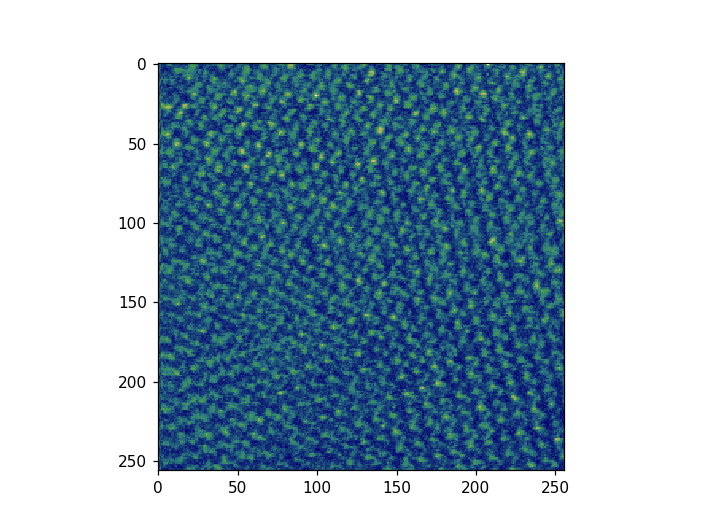

<IPython.core.display.Javascript object>


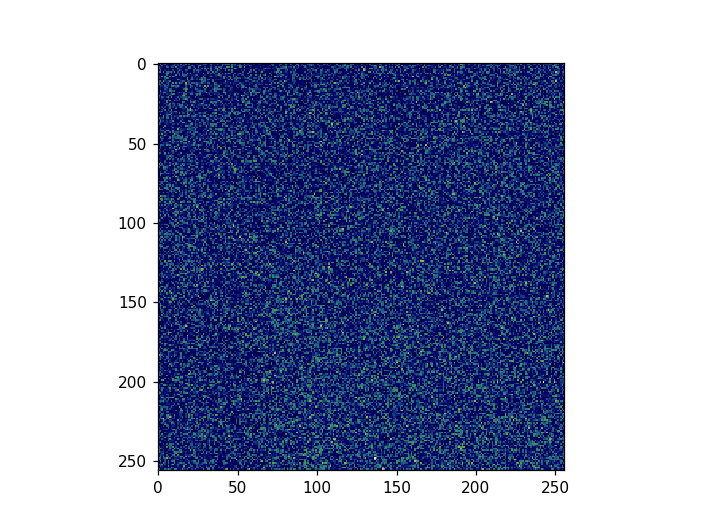

In [18]:
print("Difference between sparse and dense result: ", np.sum(result - sparse_result))
fig, axes = plt.subplots()
axes.imshow(sparse_result[0], cmap=cm.gist_earth)
fig, axes = plt.subplots()
axes.imshow(sparse_result[1], cmap=cm.gist_earth)